In [2]:
import torch
import numpy as np
import argparse
import time
from pinn.neural_net import PINN
from pinn.util import log
from pathlib import Path

import matplotlib.pyplot as plt
from scipy.io import loadmat

In [15]:
pars = dict()
pars['xi'] = 0
pars['xf'] = 1
pars['yi'] = 0
pars['yf'] = 1
pars['ti'] = 0
pars['tf'] = 1
pars['nu'] = 0.01/np.pi
print(0.01/np.pi)
2e-2

0.003183098861837907


0.02

In [67]:
def get_args():
    parser = argparse.ArgumentParser(
        prog='Training step',
        usage='%(prog)s [options] parser',
        description='Parser for hyperparams training')
    #创建解析器
    
    parser.add_argument('--path',
                        type=str,
                        default='',
                        help='Use to manually select the model file name')
    ##文件路径
    parser.add_argument('--solution',
                        type=str,
                        default='reference_solution.mat',
                        help='File containing the solution via simulation')
    #缺省为我们的真实解 包含通过模拟解决方案的文件
    parser.add_argument('--comment',
                        type=str,
                        default='',
                        help='String to be added to the end of the automatically generated file name')
    #要添加到自动生成文件名末尾的字符串
    parser.add_argument('--folder',
                        type=str,
                        default='models',
                        help='Folder where the automatically named model will be saved')   
    #保存自动命名模型的文件夹，文件名为models
    parser.add_argument('--resume',
                        type=str,
                        default='',
                        help='Model to be used as initial guess')
    #模型将被用作初始化
    parser.add_argument('--nf',
                        type=int,
                        default=10000,
                        help='Number of function evaluation points')
    #f方程（PDE方程）训练点的数量
    parser.add_argument('--ns',
                        type=int,
                        default=1000,
                        help='Number of solution points')
    #解的数量
    parser.add_argument('--epochs',
                        type=int,
                        default=100000,
                        help='Number of epochs for training')
    #epochs = 100000
    parser.add_argument('--nlayers',
                        type=int,
                        default=2,
                        help='MLP number residual blocks')
    #
    parser.add_argument('--nneurons',
                        type=int,
                        default=20,
                        help='MLP number neurons per layer')
    #每层神经元20个
    parser.add_argument('--shuffle',
                        type=int,
                        default=0,
                        help='Reshuffle sample every n itertions - 0 for fixed sample')
    #每过n轮重新排序样本
    parser.add_argument('--seed',
                        type=int,
                        default=1,
                        help='Random seed')                
    #随机种子
    parser.add_argument('--opt_method',
                        type=str,
                        default='adam',
                        help='Optimization algorithm (adam, lbfgs or sgd)')
    #adam优化算法
    parser.add_argument('--opt_lr',
                        type=float,
                        default=1e-2,
                        help='Learning rate for the optimization algorithm')
    #学习率0.01
    parser.add_argument('--loss',
                        type=str,
                        default='l1',
                        help='Type of reduction to be used for each loss (l1 or mse)')
    #损失函数类型：l1或mse
    parser.add_argument('--dev',
                        type=str,
                        default=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
                        help='Device to run the model')
    #运行模型gpu
    args = parser.parse_args(args=[])
    
    return args

In [68]:
# Retrive arguments

args = get_args()
nf = args.nf  #nf=10000
ns = args.ns  #ns=1000
pars['epochs'] = args.epochs
pars['shuffle'] = args.shuffle
device = args.dev
resume = args.resume
pars['solution_file'] = args.solution


pars['opt_method'] = args.opt_method
pars['opt_lr'] = args.opt_lr
pars['loss_type'] = args.loss

pars['layers'] = [args.nneurons for i in range(0,args.nlayers)]
pars

TypeError: unhashable type: 'numpy.ndarray'

In [69]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)



In [70]:
if len(args.path) == 0:
    
    pars['save_path'] = Path(f'{args.folder}/model_nf{nf}_ns{ns}_MLPRes_2x{args.nlayers}x{args.nneurons}_shuffle{args.shuffle}_seed{args.seed}_{args.opt_method}_lr{args.opt_lr}_loss_{args.loss}{args.comment}.pt')
else:
    pars['save_path'] = Path(args.path)



In [7]:
log.info(f'Model will be saved to: {pars["save_path"]}')
log.info(f'Number of samples - Function evaluation: {nf}, Solution samples: {ns}')
log.info(f'Using device: {device}')

<module>: Model will be saved to: models\model_nf10000_ns1000_MLPRes_2x2x20_shuffle0_seed1_adam_lr0.01_loss_l1.pt
<module>: Number of samples - Function evaluation: 10000, Solution samples: 1000
<module>: Using device: cuda


In [8]:
model = PINN(nf, ns, pars, device)
model

In [9]:
data = loadmat(pars['solution_file'])

[x, t, y] = np.meshgrid(data['x'],data['t'],data['y'])


t = t.flatten().reshape(-1, 1)
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

u = data['uref'].transpose((2,1,0)).flatten().reshape(-1, 1)
v = data['vref'].transpose((2,1,0)).flatten().reshape(-1, 1)
u.shape

(1030301, 1)

In [10]:
Exactu = np.real(data['uref']) #real函数返回实部，提取出精确解 
Exactv = np.real(data['vref']) #real函数返回实部，提取出精确解 
Exactu

array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00394265,  0.0039078 ,  0.0038642 , ...,  0.00085219,
          0.00084281,  0.00083359],
        [ 0.00786974,  0.00779393,  0.00770257, ...,  0.00169956,
          0.00168088,  0.00166253],
        ...,
        [-0.00786974, -0.00779393, -0.00770257, ..., -

In [11]:
mse_testu = Exactu[:,:,50].astype(np.float32)#u精确解提取
mse_testv = Exactv[:,:,50].astype(np.float32)#u精确解提取
mu_shape = mse_testu.shape
mv_shape = mse_testv.shape
t_plot = data['t'].flatten()[:, None]  #展开成1维度，flatten展0维，[:,none]加一维
x_plot = data['x'].flatten()[:, None]
y_plot = data['y'].flatten()[:, None]

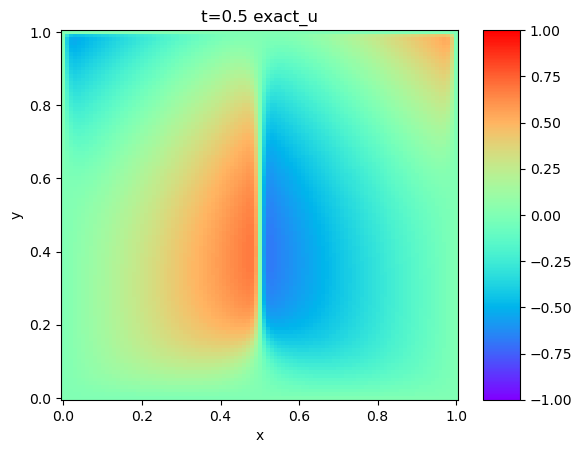

In [12]:
plt.cla()  #清除axes 画图
plt.pcolormesh(np.squeeze(x_plot, axis=1), np.squeeze(y_plot, axis=1),
                   mse_testu, cmap='rainbow')
#squeeze降成一维  .detach阻断反向传播
    #rainbow颜色显示具体函数值
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.mappable.set_clim(-1, 1)
#设置颜色组成及对应关系
plt.xlabel('x')
plt.ylabel('y')
#plt.savefig('./result_plot/Burger2d_exact_u.png', bbox_inches='tight', format='png')
plt.title("t=0.5 exact_u")
plt.show()

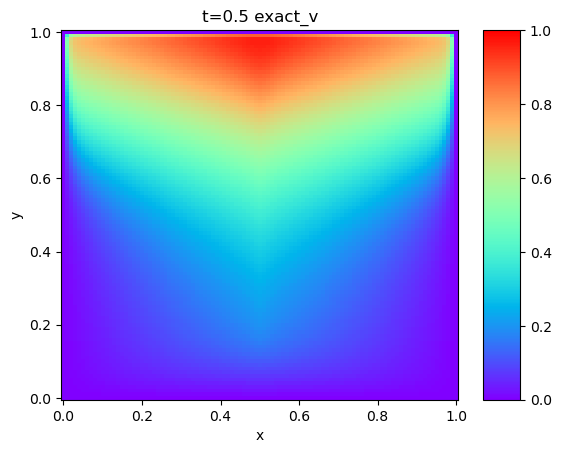

(1030301, 1)

In [13]:
plt.cla()  #清除axes 画图
plt.pcolormesh(np.squeeze(x_plot, axis=1), np.squeeze(y_plot, axis=1),
                   mse_testv, cmap='rainbow')
#squeeze降成一维  .detach阻断反向传播
    #rainbow颜色显示具体函数值
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.mappable.set_clim(0, 1)
#设置颜色组成及对应关系
plt.xlabel('x')
plt.ylabel('y')
plt.title("t=0.5 exact_v")
#plt.savefig('./result_plot/Burger2d_exact_v.png', bbox_inches='tight', format='png')
plt.show()
x.shape

In [14]:
X1,Y1 = np.meshgrid(x_plot, y_plot)
X1star = np.hstack((X1.flatten()[:, None], Y1.flatten()[:, None]))
X1star = X1star.astype(np.float32) #数据转换为np
X1star = torch.from_numpy(X1star).cuda().requires_grad_(True)  #换成tensor张量 Gpu计算，可求导
X1 = X1star[:,1:2]
Y1 = X1star[:,0:1]
x_plot1 = X1.cuda().requires_grad_(True).to(torch.float32)
y_plot1 = Y1.cuda().requires_grad_(True).to(torch.float32)
t_plot1 = (0.5 * torch.ones_like(x_plot1)
               ).requires_grad_(True).to(torch.float32)
uv_plot_1 = model.net(torch.cat([t_plot1, x_plot1, y_plot1], dim=1))
                    #.net(torch.hstack((t,x,y))
u_plot = uv_plot_1[:, 0:1]
v_plot = uv_plot_1[:, 1:2]
X1.shape

torch.Size([10201, 1])

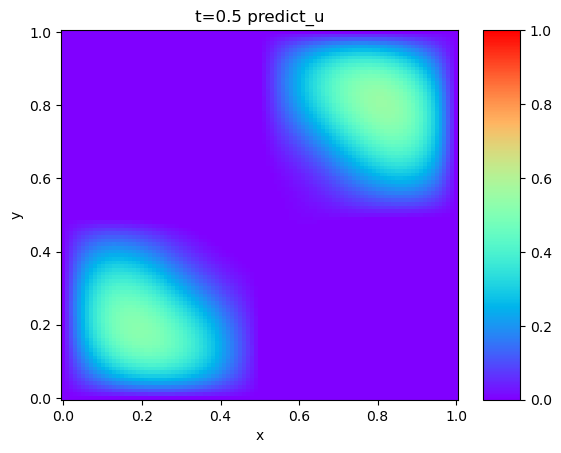

In [15]:
plt.cla()  #清除axes 画图
plt.pcolormesh(np.squeeze(x_plot, axis=1), np.squeeze(y_plot, axis=1),
                   u_plot.cpu().detach().numpy().reshape(mv_shape).T, cmap='rainbow')
#squeeze降成一维  .detach阻断反向传播
    #rainbow颜色显示具体函数值
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.mappable.set_clim(0, 1)
#设置颜色组成及对应关系
plt.xlabel('x')
plt.ylabel('y')
plt.title("t=0.5 predict_u")
#plt.savefig('./result_plot/Burger2d_pretict_u.png', bbox_inches='tight', format='png')
plt.show()

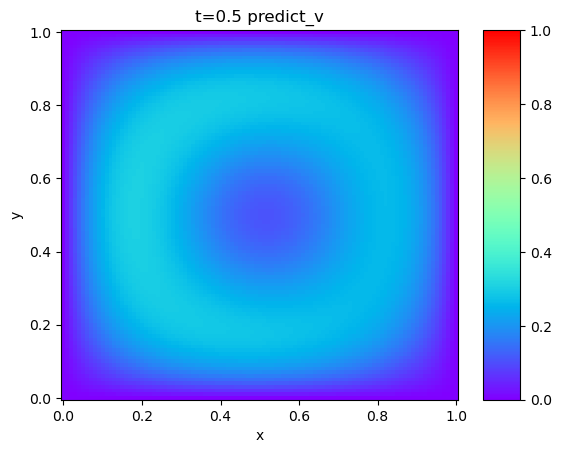

In [16]:
plt.cla()  #清除axes 画图
plt.pcolormesh(np.squeeze(x_plot, axis=1), np.squeeze(y_plot, axis=1),
                   v_plot.cpu().detach().numpy().reshape(mv_shape).T, cmap='rainbow')
#squeeze降成一维  .detach阻断反向传播
    #rainbow颜色显示具体函数值
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.mappable.set_clim(0, 1)
#设置颜色组成及对应关系
plt.xlabel('x')
plt.ylabel('y')
plt.title("t=0.5 predict_v")
#plt.savefig('./result_plot/Burger2d_pretict_v.png', bbox_inches='tight', format='png')
plt.show()

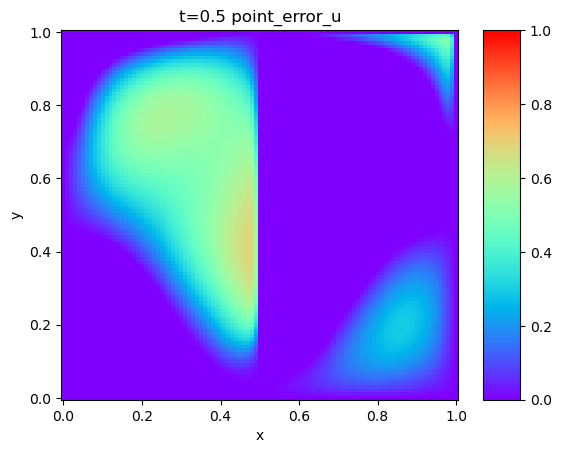

In [17]:
plt.cla()  #清除axes 画图
plt.pcolormesh(np.squeeze(x_plot, axis=1), np.squeeze(y_plot, axis=1),
                   mse_testu-u_plot.cpu().detach().numpy().reshape(mv_shape).T, cmap='rainbow')
#squeeze降成一维  .detach阻断反向传播
    #rainbow颜色显示具体函数值
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.mappable.set_clim(0, 1)
#设置颜色组成及对应关系
plt.xlabel('x')
plt.ylabel('y')
plt.title("t=0.5 point_error_u")
#plt.savefig('./result_plot/Burger2d_point_error_u.png', bbox_inches='tight', format='png')
plt.show()

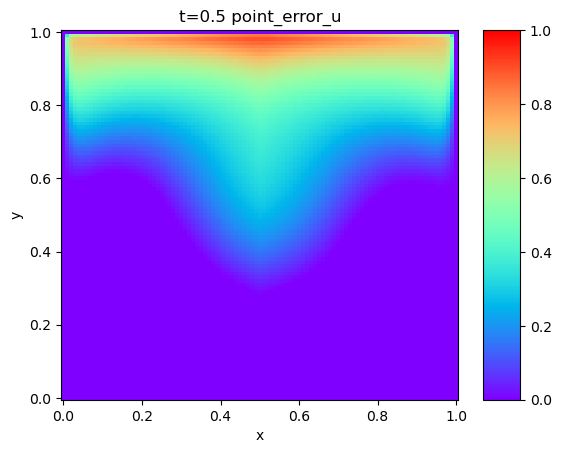

In [18]:
plt.cla()  #清除axes 画图
plt.pcolormesh(np.squeeze(x_plot, axis=1), np.squeeze(y_plot, axis=1),
                   mse_testv-v_plot.cpu().detach().numpy().reshape(mv_shape).T, cmap='rainbow')
#squeeze降成一维  .detach阻断反向传播
    #rainbow颜色显示具体函数值
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.mappable.set_clim(0, 1)
#设置颜色组成及对应关系
plt.xlabel('x')
plt.ylabel('y')
plt.title("t=0.5 point_error_u")
#plt.savefig('./result_plot/Burger2d_point_error_u.png', bbox_inches='tight', format='png')
plt.show()

In [19]:
#t=0.5 y=0.15 预测解与真实解

Text(0.5, 1.0, 't = 0.5 y=0.4')

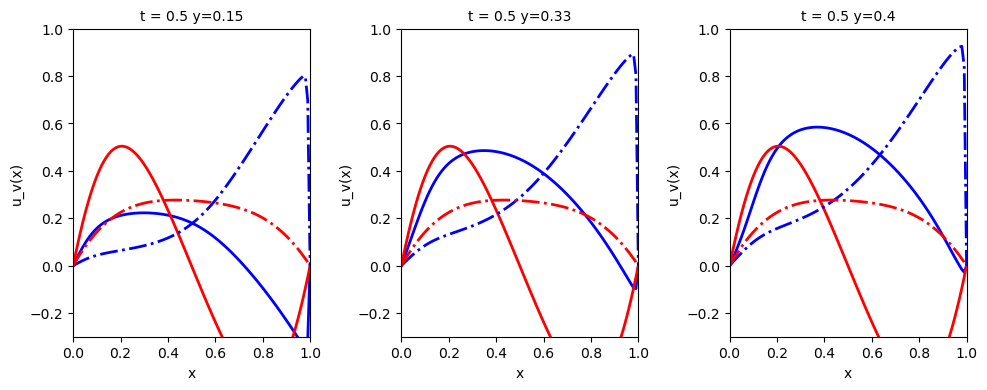

In [20]:
# 六幅子图，分别是
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
x_15 = x_plot.astype(np.float32)
x_15 = torch.from_numpy(x_15).cuda().requires_grad_(True)
t_15 = (0.5 * torch.ones_like(x_15)).requires_grad_(True)
y_15 = (0.15 * torch.ones_like(x_15)).requires_grad_(True)
uv_15 = model.net(torch.cat([t_15, x_15, y_15], dim=1))
u_15 = uv_15[:,0:1]
v_15 = uv_15[:,1:2]
ax[0].plot(x_plot, Exactu[:,15,50], 'b-', linewidth=2)  # 蓝线是精确解
ax[0].plot(x_plot, u_15.reshape((-1, 1)).detach().cpu().numpy(), 'r-', lw='2')  # 红是预测
ax[0].plot(x_plot, Exactv[:,15,50], 'b-.', linewidth=2)  # 蓝线是精确解
ax[0].plot(x_plot, v_15.reshape((-1, 1)).detach().cpu().numpy(), 'r-.', lw='2')  # 红是预测
ax[0].set_xlabel('x')
ax[0].set_ylabel('u_v(x)')
ax[0].axis('square')
ax[0].set_xlim([0, 1])
ax[0].set_ylim([-0.3, 1])
ax[0].set_title('t = 0.5 y=0.15', fontsize=10)
# 第二幅子图
x_33 = x_plot.astype(np.float32)
x_33 = torch.from_numpy(x_33).cuda().requires_grad_(True)
t_33 = (0.5 * torch.ones_like(x_33)).requires_grad_(True)
y_33 = (0.33 * torch.ones_like(x_33)).requires_grad_(True)
uv_33 = model.net(torch.cat([t_33, x_33, y_33], dim=1))
u_33 = uv_33[:,0:1]
v_33 = uv_33[:,1:2]
ax[1].plot(x_plot, Exactu[:,33,50], 'b-', linewidth=2)  # 蓝线是精确解
ax[1].plot(x_plot, u_15.reshape((-1, 1)).detach().cpu().numpy(), 'r-', lw='2')  # 红是预测
ax[1].plot(x_plot, Exactv[:,33,50], 'b-.', linewidth=2)  # 蓝线是精确解
ax[1].plot(x_plot, v_15.reshape((-1, 1)).detach().cpu().numpy(), 'r-.', lw='2')  # 红是预测
ax[1].set_xlabel('x')
ax[1].set_ylabel('u_v(x)')
ax[1].axis('square')
ax[1].set_xlim([0, 1])
ax[1].set_ylim([-0.3, 1])
ax[1].set_title('t = 0.5 y=0.33', fontsize=10)
# 第三幅子图
x_40 = x.astype(np.float32)
x_40 = torch.from_numpy(x_40).cuda().requires_grad_(True)
t_40 = (0.5 * torch.ones_like(x_40)).requires_grad_(True)
y_40 = (0.4 * torch.ones_like(x_40)).requires_grad_(True)
uv_40 = model.net(torch.cat([t_40, x_40, y_40], dim=1))
u_40 = uv_40[:,0:1]
v_40 = uv_40[:,1:2]
ax[2].plot(x_plot, Exactu[:,40,50], 'b-', linewidth=2)  # 蓝线是精确解
ax[2].plot(x_plot, u_15.reshape((-1, 1)).detach().cpu().numpy(), 'r-', lw='2')  # 红是预测
ax[2].plot(x_plot, Exactv[:,40,50], 'b-.', linewidth=2)  # 蓝线是精确解
ax[2].plot(x_plot, v_15.reshape((-1, 1)).detach().cpu().numpy(), 'r-.', lw='2')  # 红是预测
ax[2].set_xlabel('x')
ax[2].set_ylabel('u_v(x)')
ax[2].axis('square')
ax[2].set_xlim([0, 1])
ax[2].set_ylim([-0.3, 1])
ax[2].set_title('t = 0.5 y=0.4', fontsize=10)

Text(0.5, 1.0, 't = 0.5 x=0.87')

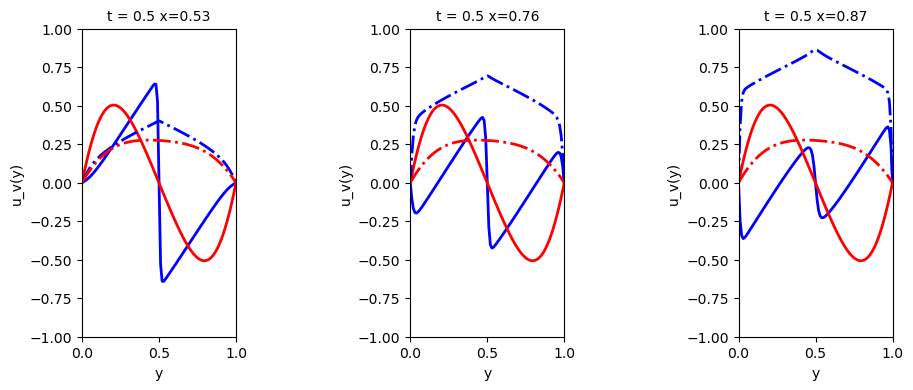

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# 第一幅子图
y_53 = x_plot.astype(np.float32)
y_53 = torch.from_numpy(y_53).cuda().requires_grad_(True)
t_53 = (0.5 * torch.ones_like(y_53)).requires_grad_(True)
x_53 = (0.53 * torch.ones_like(y_53)).requires_grad_(True)
uv_53 = model.net(torch.cat([t_53, x_53, y_53], dim=1))
u_53 = uv_53[:,0:1]
v_53 = uv_53[:,1:2]
ax[0].plot(x_plot, Exactu[53,:,50], 'b-', linewidth=2)  # 蓝线是精确解
ax[0].plot(x_plot, u_15.reshape((-1, 1)).detach().cpu().numpy(), 'r-', lw='2')  # 红是预测
ax[0].plot(x_plot, Exactv[53,:,50], 'b-.', linewidth=2)  # 蓝线是精确解
ax[0].plot(x_plot, v_15.reshape((-1, 1)).detach().cpu().numpy(), 'r-.', lw='2')  # 红是预测
ax[0].set_xlabel('y')
ax[0].set_ylabel('u_v(y)')
ax[0].axis('square')
ax[0].set_xlim([0, 1])
ax[0].set_ylim([-1, 1])
ax[0].set_title('t = 0.5 x=0.53', fontsize=10)

# 第二幅子图
y_76 = x_plot.astype(np.float32)
y_76 = torch.from_numpy(y_76).cuda().requires_grad_(True)
t_76 = (0.5 * torch.ones_like(y_76)).requires_grad_(True)
x_76 = (0.53 * torch.ones_like(y_76)).requires_grad_(True)
uv_76 = model.net(torch.cat([t_76, x_76, y_76], dim=1))
u_76 = uv_76[:,0:1]
v_76 = uv_76[:,1:2]
ax[1].plot(x_plot, Exactu[76,:,50], 'b-', linewidth=2)  # 蓝线是精确解
ax[1].plot(x_plot, u_15.reshape((-1, 1)).detach().cpu().numpy(), 'r-', lw='2')  # 红是预测
ax[1].plot(x_plot, Exactv[76,:,50], 'b-.', linewidth=2)  # 蓝线是精确解
ax[1].plot(x_plot, v_15.reshape((-1, 1)).detach().cpu().numpy(), 'r-.', lw='2')  # 红是预测
ax[1].set_xlabel('y')
ax[1].set_ylabel('u_v(y)')
ax[1].axis('square')
ax[1].set_xlim([0, 1])
ax[1].set_ylim([-1, 1])
ax[1].set_title('t = 0.5 x=0.76', fontsize=10)
# 第三幅子图
y_87= x.astype(np.float32)
y_87 = torch.from_numpy(y_87).cuda().requires_grad_(True)
t_87 = (0.5 * torch.ones_like(y_87)).requires_grad_(True)
x_87 = (0.53 * torch.ones_like(y_87)).requires_grad_(True)
uv_87 = model.net(torch.cat([t_87, x_87, y_87], dim=1))
u_87 = uv_87[:,0:1]
v_87 = uv_87[:,1:2]
ax[2].plot(x_plot, Exactu[87,:,50], 'b-', linewidth=2)  # 蓝线是精确解
ax[2].plot(x_plot, u_15.reshape((-1, 1)).detach().cpu().numpy(), 'r-', lw='2')  # 红是预测
ax[2].plot(x_plot, Exactv[87,:,50], 'b-.', linewidth=2)  # 蓝线是精确解
ax[2].plot(x_plot, v_15.reshape((-1, 1)).detach().cpu().numpy(), 'r-.', lw='2')  # 红是预测
ax[2].set_xlabel('y')
ax[2].set_ylabel('u_v(y)')
ax[2].axis('square')
ax[2].set_xlim([0, 1])
ax[2].set_ylim([-1, 1])
ax[2].set_title('t = 0.5 x=0.87', fontsize=10)

In [22]:
data = loadmat(pars['solution_file'])

In [23]:
[x, t, y] = np.meshgrid(data['x'],data['t'],data['y'])

In [24]:
t = t.flatten().reshape(-1, 1)
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)
u = data['uref'].transpose((2,1,0)).flatten().reshape(-1, 1)
v = data['vref'].transpose((2,1,0)).flatten().reshape(-1, 1)
u

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [25]:
t.shape[0]
15*101+101*101*50+101

511666

In [26]:
ind = np.random.choice(t.shape[0], size=1000)
ind

array([ 401725,  371820,  608431,  600072,  224525,     911,  114522,
        246707,  790542,  272340,   78140,  516768,  789041,  722068,
        251725,   50509,  852335,  409688,  952592,  539481,    7359,
        703190,  745544, 1021067,  181428,  251883,  592708,  586148,
         59206,  849801,  411151,   19840,  329486,  762145, 1012164,
        341718,  528764,  935198,   29126,  633056,  818525,  405900,
        150233,  443374,  661211,  599122,  367669,  475382,  440285,
        980581,  863562,  458367,  344235,  114963,  723156,  992972,
        275624,  512648,  124554,  359550,  845819,  895380,  950512,
         33272,  639448,  187036,  214753,  302993,  499308,  387733,
        981639,   45228,  410835,   88691,  331722,  946919,  687628,
        498833,  540661,  134436,  359998,  976892,  454260,  681390,
        479949,  923707,  389390,  434857,  520334,   45219,  779481,
        773161,  916347,  728832,  933077,  581056,  409128,  898480,
          4198,  763

In [27]:
t[510050:520251]

array([[0.5],
       [0.5],
       [0.5],
       ...,
       [0.5],
       [0.5],
       [0.5]])

In [28]:
int = np.arange(510050,520251)
int

array([510050, 510051, 510052, ..., 520248, 520249, 520250])

In [29]:
y[int]

array([[0.  ],
       [0.01],
       [0.02],
       ...,
       [0.98],
       [0.99],
       [1.  ]])

In [30]:
inx = np.arange(511565,511666)

In [31]:
#x[inx]

In [32]:
#首先是t=0.5  x=0.15  


Text(0.5, 1.0, 't = 0.5 y=0.4')

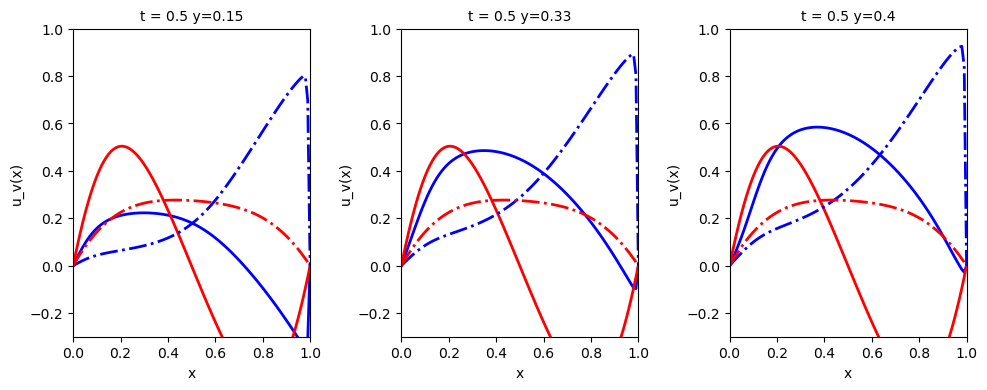

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
x_15 = x_plot.astype(np.float32)
x_15 = torch.from_numpy(x_15).cuda().requires_grad_(True)
t_15 = (0.5 * torch.ones_like(x_15)).requires_grad_(True)
y_15 = (0.15 * torch.ones_like(x_15)).requires_grad_(True)
uv_15 = model.net(torch.cat([t_15, x_15, y_15], dim=1))
u_15 = uv_15[:,0:1]
v_15 = uv_15[:,1:2]
ax[0].plot(y[inx], u[inx], 'b-', linewidth=2)  # 蓝线是精确解
ax[0].plot(y[inx], u_15.reshape((-1, 1)).detach().cpu().numpy(), 'r-', lw='2')  # 红是预测
ax[0].plot(y[inx], v[inx], 'b-.', linewidth=2)  # 蓝线是精确解
ax[0].plot(y[inx], v_15.reshape((-1, 1)).detach().cpu().numpy(), 'r-.', lw='2')  # 红是预测
ax[0].set_xlabel('x')
ax[0].set_ylabel('u_v(x)')
ax[0].axis('square')
ax[0].set_xlim([0, 1])
ax[0].set_ylim([-0.3, 1])
ax[0].set_title('t = 0.5 y=0.15', fontsize=10)
# 第二幅子图
x_33 = x_plot.astype(np.float32)
x_33 = torch.from_numpy(x_33).cuda().requires_grad_(True)
t_33 = (0.5 * torch.ones_like(x_33)).requires_grad_(True)
y_33 = (0.33 * torch.ones_like(x_33)).requires_grad_(True)
uv_33 = model.net(torch.cat([t_33, x_33, y_33], dim=1))
u_33 = uv_33[:,0:1]
v_33 = uv_33[:,1:2]
ax[1].plot(x_plot, Exactu[:,33,50], 'b-', linewidth=2)  # 蓝线是精确解
ax[1].plot(x_plot, u_15.reshape((-1, 1)).detach().cpu().numpy(), 'r-', lw='2')  # 红是预测
ax[1].plot(x_plot, Exactv[:,33,50], 'b-.', linewidth=2)  # 蓝线是精确解
ax[1].plot(x_plot, v_15.reshape((-1, 1)).detach().cpu().numpy(), 'r-.', lw='2')  # 红是预测
ax[1].set_xlabel('x')
ax[1].set_ylabel('u_v(x)')
ax[1].axis('square')
ax[1].set_xlim([0, 1])
ax[1].set_ylim([-0.3, 1])
ax[1].set_title('t = 0.5 y=0.33', fontsize=10)
# 第三幅子图
x_40 = x.astype(np.float32)
x_40 = torch.from_numpy(x_40).cuda().requires_grad_(True)
t_40 = (0.5 * torch.ones_like(x_40)).requires_grad_(True)
y_40 = (0.4 * torch.ones_like(x_40)).requires_grad_(True)
uv_40 = model.net(torch.cat([t_40, x_40, y_40], dim=1))
u_40 = uv_40[:,0:1]
v_40 = uv_40[:,1:2]
ax[2].plot(x_plot, Exactu[:,40,50], 'b-', linewidth=2)  # 蓝线是精确解
ax[2].plot(x_plot, u_15.reshape((-1, 1)).detach().cpu().numpy(), 'r-', lw='2')  # 红是预测
ax[2].plot(x_plot, Exactv[:,40,50], 'b-.', linewidth=2)  # 蓝线是精确解
ax[2].plot(x_plot, v_15.reshape((-1, 1)).detach().cpu().numpy(), 'r-.', lw='2')  # 红是预测
ax[2].set_xlabel('x')
ax[2].set_ylabel('u_v(x)')
ax[2].axis('square')
ax[2].set_xlim([0, 1])
ax[2].set_ylim([-0.3, 1])
ax[2].set_title('t = 0.5 y=0.4', fontsize=10)

In [34]:
#其次是t=0.5  y=0.53 

iny = np.arange(53+101*101*50,53+101*101*50+101*101,101)

#iny = 53+101*101*50+101*100

In [35]:
y[101*101*50:]

array([[0.  ],
       [0.01],
       [0.02],
       ...,
       [0.98],
       [0.99],
       [1.  ]])

In [37]:
def solution_plotx(t_in,x_in,pars):

    data = loadmat(pars['solution_file'])

    [x, t, y] = np.meshgrid(data['x'],data['t'],data['y'])

    t = t.flatten().reshape(-1, 1)
    x = x.flatten().reshape(-1, 1)
    y = y.flatten().reshape(-1, 1)
    u = data['uref'].transpose((2,1,0)).flatten().reshape(-1, 1)
    v = data['vref'].transpose((2,1,0)).flatten().reshape(-1, 1)

    inx = np.arange(x_in*100*101+101*101*t_in*100,x_in*100*101+101*101*t_in*100+101).astype('int64')

    X = np.hstack((t[inx],x[inx],y[inx]))
    Y = np.hstack((u[inx],v[inx]))

    return X, Y

In [38]:
def solution_ploty(t_in,y_in,pars):

    data = loadmat(pars['solution_file'])

    [x, t, y] = np.meshgrid(data['x'],data['t'],data['y'])

    t = t.flatten().reshape(-1, 1)
    x = x.flatten().reshape(-1, 1)
    y = y.flatten().reshape(-1, 1)
    u = data['uref'].transpose((2,1,0)).flatten().reshape(-1, 1)
    v = data['vref'].transpose((2,1,0)).flatten().reshape(-1, 1)

    iny = np.arange(y_in*100+101*101*t_in*100,y_in*100+101*101*t_in*100+101*101,101).astype('int64')

    X = np.hstack((t[iny],x[iny],y[iny]))
    Y = np.hstack((u[iny],v[iny]))

    return X, Y

In [39]:
[X_s,Y_s] = solution_plotx(0.5,0.15,pars)   #精确解的数量X_s为txy，Y_s为u,v

In [40]:
X_s[:,2]

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [41]:
Y_s

array([[ 0.        ,  0.        ],
       [ 0.02036533,  0.00559701],
       [ 0.04026877,  0.01106097],
       [ 0.05935222,  0.01629191],
       [ 0.07735846,  0.02122226],
       [ 0.09411771,  0.02581226],
       [ 0.10953443,  0.03004512],
       [ 0.12357437,  0.03392226],
       [ 0.13625192,  0.03745877],
       [ 0.14761799,  0.04067932],
       [ 0.15774892,  0.04361467],
       [ 0.16673683,  0.04629871],
       [ 0.17468154,  0.04876624],
       [ 0.18168432,  0.05105133],
       [ 0.18784332,  0.05318621],
       [ 0.19325054,  0.05520068],
       [ 0.19799004,  0.05712181],
       [ 0.2021371 ,  0.05897394],
       [ 0.20575814,  0.06077883],
       [ 0.20891107,  0.0625559 ],
       [ 0.21164584,  0.06432255],
       [ 0.21400528,  0.06609447],
       [ 0.21602583,  0.06788597],
       [ 0.21773835,  0.06971022],
       [ 0.21916877,  0.07157955],
       [ 0.22033878,  0.07350568],
       [ 0.22126636,  0.07549987],
       [ 0.22196623,  0.07757317],
       [ 0.22245028,

In [45]:
[X_s,Y_s] = solution_plotx(0.5,0.15,pars)   #精确解的数量X_s为txy，Y_s为u,v
X_s = torch.tensor(X_s,dtype=torch.float,requires_grad=True).to(device)
Y_s = torch.tensor(Y_s,dtype=torch.float,requires_grad=False).to(device)
Y_pred = model.net(X_s)
Y_pred

tensor([[ 0.0000e+00,  0.0000e+00],
        [ 4.8768e-02,  1.6821e-02],
        [ 9.5352e-02,  3.3015e-02],
        [ 1.3964e-01,  4.8586e-02],
        [ 1.8152e-01,  6.3540e-02],
        [ 2.2093e-01,  7.7884e-02],
        [ 2.5780e-01,  9.1626e-02],
        [ 2.9206e-01,  1.0477e-01],
        [ 3.2370e-01,  1.1734e-01],
        [ 3.5267e-01,  1.2933e-01],
        [ 3.7899e-01,  1.4076e-01],
        [ 4.0264e-01,  1.5164e-01],
        [ 4.2364e-01,  1.6198e-01],
        [ 4.4203e-01,  1.7179e-01],
        [ 4.5784e-01,  1.8110e-01],
        [ 4.7111e-01,  1.8990e-01],
        [ 4.8190e-01,  1.9823e-01],
        [ 4.9028e-01,  2.0608e-01],
        [ 4.9631e-01,  2.1349e-01],
        [ 5.0008e-01,  2.2046e-01],
        [ 5.0166e-01,  2.2700e-01],
        [ 5.0115e-01,  2.3314e-01],
        [ 4.9863e-01,  2.3889e-01],
        [ 4.9419e-01,  2.4427e-01],
        [ 4.8794e-01,  2.4929e-01],
        [ 4.7997e-01,  2.5397e-01],
        [ 4.7038e-01,  2.5832e-01],
        [ 4.5926e-01,  2.623

Text(0.5, 1.0, 't = 0.5 y=0.4')

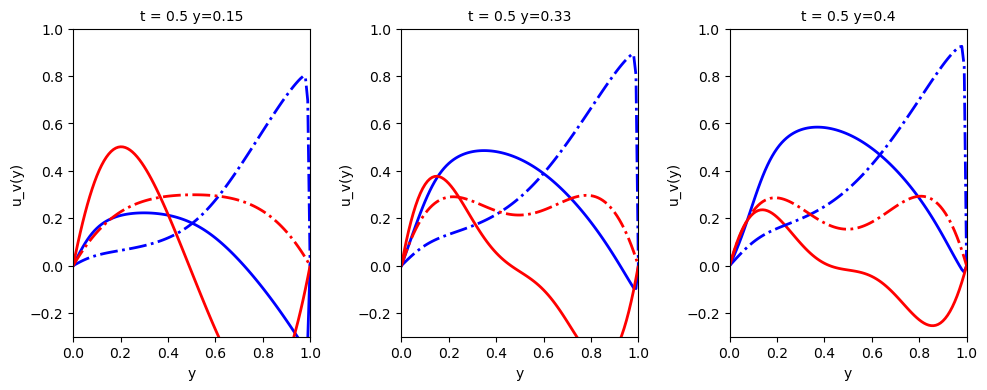

In [55]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

x_in = 0.15
t_in = 0.5
[X_s,Y_s] = solution_plotx(t_in,x_in,pars)   #精确解的数量X_s为txy，Y_s为u,v
X_s = torch.tensor(X_s,dtype=torch.float,requires_grad=True).to(device)

x_plot = X_s[:,2].detach().cpu().numpy()
Y_pred =  model.net(X_s)
u_15_exc = Y_s[:,0:1]
v_15_exc = Y_s[:,1:2]
u_15_pre = Y_pred[:,0:1]
v_15_pre = Y_pred[:,1:2]

ax[0].plot(x_plot , u_15_exc, 'b-', linewidth=2)  # 蓝线是精确解
ax[0].plot(x_plot , u_15_pre.reshape((-1, 1)).detach().cpu().numpy(), 'r-', lw='2')  # 红是预测
ax[0].plot(x_plot , v_15_exc, 'b-.', linewidth=2)  # 蓝线是精确解
ax[0].plot(x_plot , v_15_pre.reshape((-1, 1)).detach().cpu().numpy(), 'r-.', lw='2')  # 红是预测
ax[0].set_xlabel('y')
ax[0].set_ylabel('u_v(y)')
ax[0].axis('square')
ax[0].set_xlim([0, 1])
ax[0].set_ylim([-0.3, 1])
ax[0].set_title('t = 0.5 y=0.15', fontsize=10)


# 第二幅子图
x_in = 0.33
t_in = 0.5
[X_s,Y_s] = solution_plotx(t_in,x_in,pars)   #精确解的数量X_s为txy，Y_s为u,v
X_s = torch.tensor(X_s,dtype=torch.float,requires_grad=True).to(device)
x_plot = X_s[:,2].detach().cpu().numpy()
Y_pred =  model.net(X_s)
u_15_exc = Y_s[:,0:1]
v_15_exc = Y_s[:,1:2]
u_15_pre = Y_pred[:,0:1]
v_15_pre = Y_pred[:,1:2]

ax[1].plot(x_plot , u_15_exc, 'b-', linewidth=2)  # 蓝线是精确解
ax[1].plot(x_plot , u_15_pre.reshape((-1, 1)).detach().cpu().numpy(), 'r-', lw='2')  # 红是预测
ax[1].plot(x_plot , v_15_exc, 'b-.', linewidth=2)  # 蓝线是精确解
ax[1].plot(x_plot , v_15_pre.reshape((-1, 1)).detach().cpu().numpy(), 'r-.', lw='2')  # 红是预测
ax[1].set_xlabel('y')
ax[1].set_ylabel('u_v(y)')
ax[1].axis('square')
ax[1].set_xlim([0, 1])
ax[1].set_ylim([-0.3, 1])
ax[1].set_title('t = 0.5 y=0.33', fontsize=10)

# 第三幅子图
x_in = 0.4
t_in = 0.5
[X_s,Y_s] = solution_plotx(t_in,x_in,pars)   #精确解的数量X_s为txy，Y_s为u,v
X_s = torch.tensor(X_s,dtype=torch.float,requires_grad=True).to(device)
x_plot = X_s[:,2].detach().cpu().numpy()
Y_pred =  model.net(X_s)
u_15_exc = Y_s[:,0:1]
v_15_exc = Y_s[:,1:2]
u_15_pre = Y_pred[:,0:1]
v_15_pre = Y_pred[:,1:2]

ax[2].plot(x_plot , u_15_exc, 'b-', linewidth=2)  # 蓝线是精确解
ax[2].plot(x_plot , u_15_pre.reshape((-1, 1)).detach().cpu().numpy(), 'r-', lw='2')  # 红是预测
ax[2].plot(x_plot , v_15_exc, 'b-.', linewidth=2)  # 蓝线是精确解
ax[2].plot(x_plot , v_15_pre.reshape((-1, 1)).detach().cpu().numpy(), 'r-.', lw='2')  # 红是预测
ax[2].set_xlabel('y')
ax[2].set_ylabel('u_v(y)')
ax[2].axis('square')
ax[2].set_xlim([0, 1])
ax[2].set_ylim([-0.3, 1])
ax[2].set_title('t = 0.5 y=0.4', fontsize=10)

In [62]:
y_in = 0.53
t_in = 0.5
[X_s,Y_s] = solution_ploty(t_in,y_in,pars)   #精确解的数量X_s为txy，Y_s为u,v
X_s = torch.tensor(X_s,dtype=torch.float,requires_grad=True).to(device)
X_s

tensor([[0.5000, 0.0000, 0.5300],
        [0.5000, 0.0100, 0.5300],
        [0.5000, 0.0200, 0.5300],
        [0.5000, 0.0300, 0.5300],
        [0.5000, 0.0400, 0.5300],
        [0.5000, 0.0500, 0.5300],
        [0.5000, 0.0600, 0.5300],
        [0.5000, 0.0700, 0.5300],
        [0.5000, 0.0800, 0.5300],
        [0.5000, 0.0900, 0.5300],
        [0.5000, 0.1000, 0.5300],
        [0.5000, 0.1100, 0.5300],
        [0.5000, 0.1200, 0.5300],
        [0.5000, 0.1300, 0.5300],
        [0.5000, 0.1400, 0.5300],
        [0.5000, 0.1500, 0.5300],
        [0.5000, 0.1600, 0.5300],
        [0.5000, 0.1700, 0.5300],
        [0.5000, 0.1800, 0.5300],
        [0.5000, 0.1900, 0.5300],
        [0.5000, 0.2000, 0.5300],
        [0.5000, 0.2100, 0.5300],
        [0.5000, 0.2200, 0.5300],
        [0.5000, 0.2300, 0.5300],
        [0.5000, 0.2400, 0.5300],
        [0.5000, 0.2500, 0.5300],
        [0.5000, 0.2600, 0.5300],
        [0.5000, 0.2700, 0.5300],
        [0.5000, 0.2800, 0.5300],
        [0.500

Text(0.5, 1.0, 't = 0.5 y=0.87')

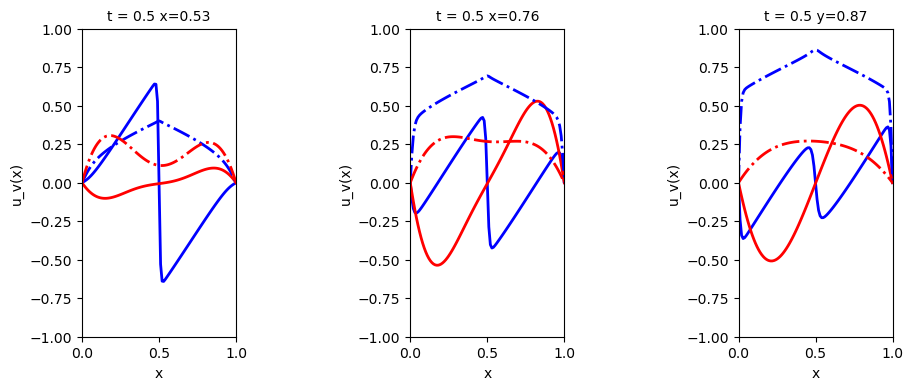

In [64]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

y_in = 0.53
t_in = 0.5
[X_s,Y_s] = solution_ploty(t_in,y_in,pars)   #精确解的数量X_s为txy，Y_s为u,v
X_s = torch.tensor(X_s,dtype=torch.float,requires_grad=True).to(device)

x_plot = X_s[:,1].detach().cpu().numpy()
Y_pred =  model.net(X_s)
u_15_exc = Y_s[:,0:1]
v_15_exc = Y_s[:,1:2]
u_15_pre = Y_pred[:,0:1]
v_15_pre = Y_pred[:,1:2]

ax[0].plot(x_plot , u_15_exc, 'b-', linewidth=2)  # 蓝线是精确解
ax[0].plot(x_plot , u_15_pre.reshape((-1, 1)).detach().cpu().numpy(), 'r-', lw='2')  # 红是预测
ax[0].plot(x_plot , v_15_exc, 'b-.', linewidth=2)  # 蓝线是精确解
ax[0].plot(x_plot , v_15_pre.reshape((-1, 1)).detach().cpu().numpy(), 'r-.', lw='2')  # 红是预测
ax[0].set_xlabel('x')
ax[0].set_ylabel('u_v(x)')
ax[0].axis('square')
ax[0].set_xlim([0, 1])
ax[0].set_ylim([-1, 1])
ax[0].set_title('t = 0.5 x=0.53', fontsize=10)


# 第二幅子图
y_in = 0.76
t_in = 0.5
[X_s,Y_s] = solution_ploty(t_in,y_in,pars)   #精确解的数量X_s为txy，Y_s为u,v
X_s = torch.tensor(X_s,dtype=torch.float,requires_grad=True).to(device)
x_plot = X_s[:,1].detach().cpu().numpy()
Y_pred =  model.net(X_s)
u_15_exc = Y_s[:,0:1]
v_15_exc = Y_s[:,1:2]
u_15_pre = Y_pred[:,0:1]
v_15_pre = Y_pred[:,1:2]

ax[1].plot(x_plot , u_15_exc, 'b-', linewidth=2)  # 蓝线是精确解
ax[1].plot(x_plot , u_15_pre.reshape((-1, 1)).detach().cpu().numpy(), 'r-', lw='2')  # 红是预测
ax[1].plot(x_plot , v_15_exc, 'b-.', linewidth=2)  # 蓝线是精确解
ax[1].plot(x_plot , v_15_pre.reshape((-1, 1)).detach().cpu().numpy(), 'r-.', lw='2')  # 红是预测
ax[1].set_xlabel('x')
ax[1].set_ylabel('u_v(x)')
ax[1].axis('square')
ax[1].set_xlim([0, 1])
ax[1].set_ylim([-1, 1])
ax[1].set_title('t = 0.5 x=0.76', fontsize=10)

# 第三幅子图
y_in = 0.87
t_in = 0.5
[X_s,Y_s] = solution_ploty(t_in,y_in,pars)   #精确解的数量X_s为txy，Y_s为u,v
X_s = torch.tensor(X_s,dtype=torch.float,requires_grad=True).to(device)
x_plot = X_s[:,1].detach().cpu().numpy()
Y_pred =  model.net(X_s)
u_15_exc = Y_s[:,0:1]
v_15_exc = Y_s[:,1:2]
u_15_pre = Y_pred[:,0:1]
v_15_pre = Y_pred[:,1:2]
inx  = np.arange(x_in*100*101+101*101*t_in*100,x_in*100*101+101*101*t_in*100+101).astype('int64')
ax[2].plot(x_plot , u_15_exc, 'b-', linewidth=2)  # 蓝线是精确解
ax[2].plot(x_plot , u_15_pre.reshape((-1, 1)).detach().cpu().numpy(), 'r-', lw='2')  # 红是预测
ax[2].plot(x_plot , v_15_exc, 'b-.', linewidth=2)  # 蓝线是精确解
ax[2].plot(x_plot , v_15_pre.reshape((-1, 1)).detach().cpu().numpy(), 'r-.', lw='2')  # 红是预测
ax[2].set_xlabel('x')
ax[2].set_ylabel('u_v(x)')
ax[2].axis('square')
ax[2].set_xlim([0, 1])
ax[2].set_ylim([-1, 1])
ax[2].set_title('t = 0.5 y=0.87', fontsize=10)